In [2]:
# can be removed if LinOT package is installed via pip
import sys
sys.path.append('../../lib')

import os
import numpy as np

import LinOT
from LinOT.Visualization import *
import LinOT.auxiliary as aux
import LinOT.SinkhornNP as Sinkhorn

import json

# HK and SHK analysis of moving disks, 3d

## Preprocessing / loading data

In [15]:
dataDir='data/TranslatedNScaledDisks/'
fileSamples=dataDir+'sampleDisks.npz'
fileCenter=dataDir+'centerTan.npz'

fileParams=dataDir + 'params.json'
fileTan=dataDir + 'tan_data_HK.npz'

### Load basic sample data

In [16]:
boundary=5.
R=.2
N=50
discr=200

X,Y=np.meshgrid(np.linspace(0,boundary,discr),np.linspace(0,boundary,discr))
points=np.transpose([X,Y],(1,2,0))

loadedSamples=np.load(fileSamples)
posNus=list(loadedSamples.values())
nus=[np.ones(pts.shape[0])/pts.shape[0] for pts in posNus]

posMu=np.load(fileCenter)['posMu']
mu=np.ones(posMu.shape[0])/posMu.shape[0]

with open(fileParams,'r') as fp:
    params=json.load(fp)

print(params)

{'setup_HKScale': 6.0, 'solver_errorGoal': 0.01, 'solver_epsStart': 100.0, 'solver_epsTarget': 0.001}


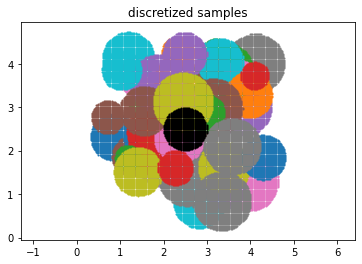

In [17]:
for pts in posNus:
    plt.scatter(pts[:,0],pts[:,1],s=1)
plt.title("discretized samples")
plt.scatter(posMu[:,0],posMu[:,1],c='k',s=1)
plt.axis("equal")
plt.show()

### Load tangent vector data

In [18]:
tanListV,tanListAlpha=list(np.load(fileTan).values())

### Application of exponential map

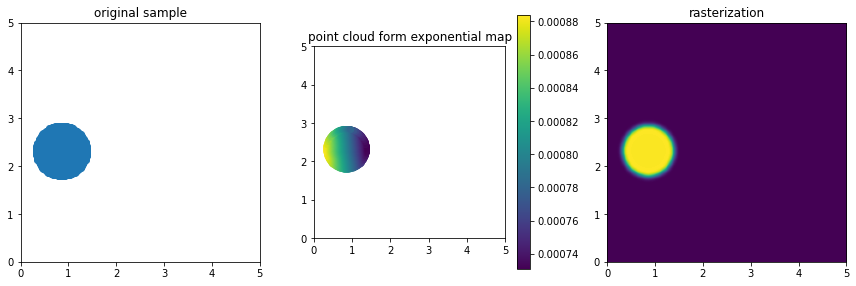

In [19]:
# on an exemplary sample: apply expontential map to tangent vector
i=0
pts=posNus[i]
tanV,tanA=tanListV[i],tanListAlpha[i]
# apply exponential map
muExp,posExp=LinOT.ExpHK(mu,posMu,tanV,tanA,kappa=params['setup_HKScale'])
# rasterize
muImg=aux.kde(posExp,muExp,points.reshape(-1,2),sigma=.009)
muImg=muImg.reshape(discr,discr)


fig=plt.figure(figsize=(12,4))
fig.add_subplot(1,3,1,aspect=1.)
plt.title("original sample")
plt.scatter(pts[:,0],pts[:,1])
plt.xlim([0,boundary])
plt.ylim([0,boundary])
fig.add_subplot(1,3,2,aspect=1.)
plt.title("point cloud form exponential map")
plt.scatter(posExp[:,0],posExp[:,1],c=muExp)
plt.xlim([0,boundary])
plt.ylim([0,boundary])
plt.colorbar()

fig.add_subplot(1,3,3)
plt.title("rasterization")
plt.imshow(muImg,extent=[0,boundary,0,boundary],origin="lower")

plt.tight_layout()
plt.show()

## PCA of whole ensemble in tangent space

In [20]:
embHK=LinOT.LinHKEmbedding(muRef=mu,posRef=posMu,kappa=params['setup_HKScale'])
embSHK=LinOT.LinSHKEmbedding(muRef=mu,posRef=posMu,kappa=params['setup_HKScale'])

embHK.addSamples((tanListV,tanListAlpha))
embHK.centerSamples()

embSHK.addSamples((tanListV,tanListAlpha),fromHK=True)
embSHK.centerSamples()

### Show PCA spectra

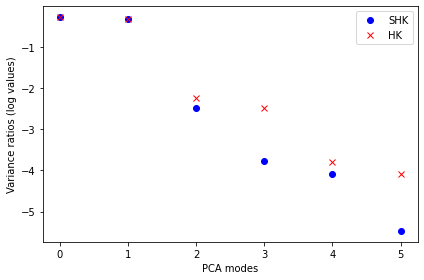

In [21]:
keep=6

embHK.performPCA(keepDim=keep)
embSHK.performPCA(keepDim=keep)

ratiosHK=embHK.pca_var/sum(embHK.pca_var)
ratiosSHK=embSHK.pca_var/sum(embSHK.pca_var)

plt.plot(np.arange(keep),np.log10(ratiosSHK),marker="o", c='b',lw=0,label='SHK')
plt.plot(np.arange(keep),np.log10(ratiosHK),marker="x", c='r',lw=0,label='HK')
plt.xticks(np.arange(keep))
plt.ylabel('Variance ratios (log values)')
plt.xlabel('PCA modes')
plt.legend()
plt.tight_layout()
plt.show()

### Show PCA embeddings

In [26]:
# compute sample disk centers for comparison
meanList=np.array([np.mean(pts,axis=0) for pts in posNus])

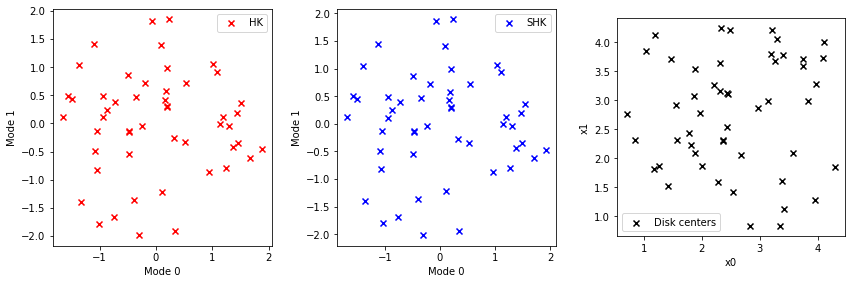

In [30]:
fig=plt.figure(figsize=(12,4),facecolor="white")

fig.add_subplot(1,3,1,aspect=1.)
plt.scatter(embHK.pca_coords[:,0],embHK.pca_coords[:,1],marker='x',c='r',label="HK")
plt.xlabel('Mode 0')
plt.ylabel('Mode 1')
plt.legend()

fig.add_subplot(1,3,2,aspect=1.)
plt.scatter(embSHK.pca_coords[:,0],embSHK.pca_coords[:,1],marker='x',c='b',label="SHK")
plt.xlabel('Mode 0')
plt.ylabel('Mode 1')
plt.legend()

fig.add_subplot(1,3,3,aspect=1.)
plt.scatter(meanList[:,0],meanList[:,1],marker='x',c='k',label="Disk centers")
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend()


plt.tight_layout()
plt.show()
# up to rotations and reflections, all three plots look very similar

### Visualize linearized mean: HK

In [32]:
# mean and rasterization
muMean,posMuMean=embHK.getMeanExp()

# rasterization
muMeanPlots=aux.kde(posMuMean,muMean,points.reshape(-1,2),sigma=.009)
muMeanPlots=muMeanPlots.reshape(discr,discr)

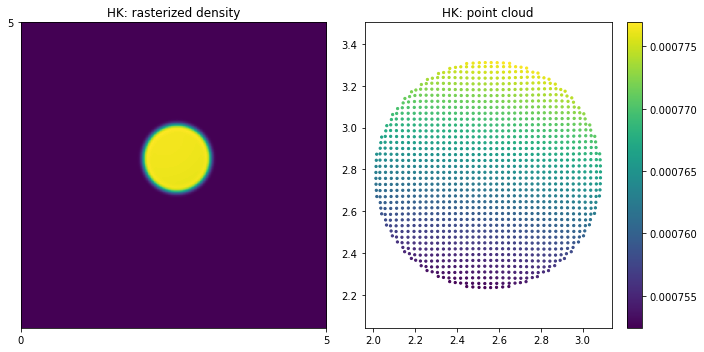

In [33]:
fig=plt.figure(figsize=(10,5))

fig.add_subplot(1,2,1)
plt.title("HK: rasterized density")
plt.imshow(muMeanPlots,extent=[0,boundary,0,boundary],origin="lower")

plt.xticks([0,boundary])
plt.yticks([boundary])

fig.add_subplot(1,2,2)
plt.title("HK: point cloud")
plt.scatter(*(posMuMean.transpose(1,0)),c=muMean,vmin=np.min(muMean),vmax=np.max(muMean),s=5)
plt.colorbar()
plt.axis("equal")

plt.tight_layout()
plt.show()

### Visualize linearized mean: SHK

In [34]:
# mean and rasterization
muMean,posMuMean=embSHK.getMeanExp()

# rasterization
muMeanPlots=aux.kde(posMuMean,muMean,points.reshape(-1,2),sigma=.009)
muMeanPlots=muMeanPlots.reshape(discr,discr)

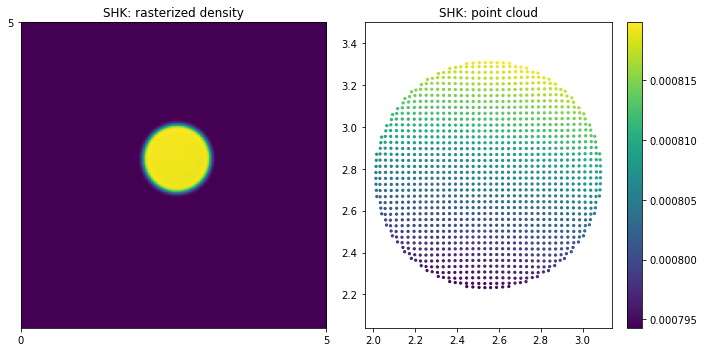

In [35]:
fig=plt.figure(figsize=(10,5))

fig.add_subplot(1,2,1)
plt.title("SHK: rasterized density")
plt.imshow(muMeanPlots,extent=[0,boundary,0,boundary],origin="lower")

plt.xticks([0,boundary])
plt.yticks([boundary])

fig.add_subplot(1,2,2)
plt.title("SHK: point cloud")
plt.scatter(*(posMuMean.transpose(1,0)),c=muMean,vmin=np.min(muMean),vmax=np.max(muMean),s=5)
plt.colorbar()
plt.axis("equal")

plt.tight_layout()
plt.show()

### Shoot along PCA modes: HK

In [36]:
# along how many modes to shoot
keepShoot=4
# how many steps for each mode
nSteps=5
# direction for each shot
directions=np.identity(keep)

timeSteps=np.linspace(-1,1,num=nSteps)

muBPlots=np.zeros((keepShoot,nSteps,discr,discr))
mass=np.zeros((keepShoot,nSteps))
for i in range(keepShoot):
    shooting=embHK.expPCA(v=directions[i],tSeq=timeSteps*embHK.pca_std[i])
    for j, (muB,posB) in enumerate(shooting):
        muBTemp=aux.kde(posB,muB,points.reshape(-1,2),sigma=.01)
        muBPlots[i,j]=muBTemp.reshape(discr,discr)
        mass[i,j]=np.sum(muB)
    # normalize all images in current row
    muBPlots[i]=muBPlots[i]/np.max(muBPlots[i])

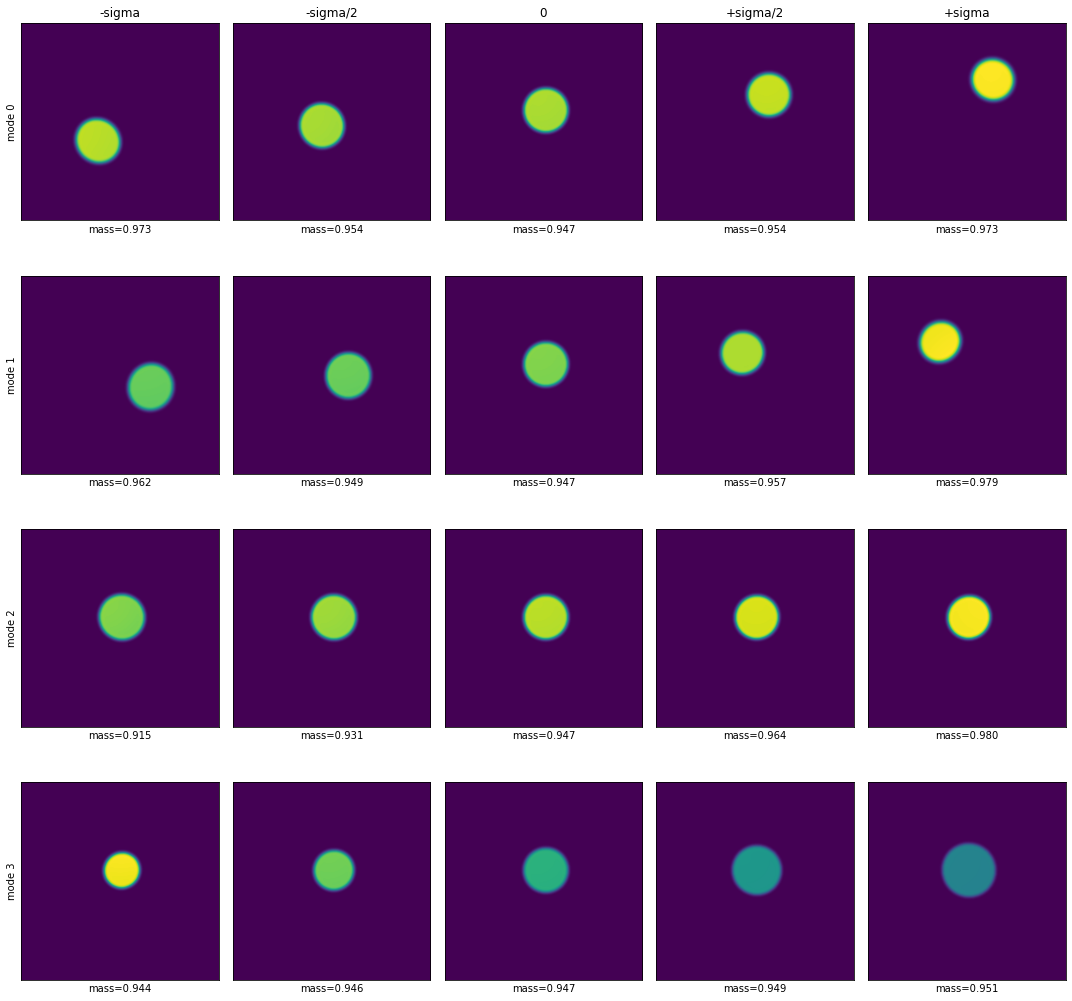

In [37]:
titleList=["-sigma","-sigma/2","0","+sigma/2","+sigma"]

fig=plt.figure(figsize=(15,15))
for i in range(keepShoot):
    for (j,t) in enumerate(timeSteps):
        fig.add_subplot(keepShoot,nSteps,i*nSteps+j+1)
        plt.xticks([])
        plt.yticks([])
        if i==0:
            plt.title(titleList[j])
        if j==0:
            plt.ylabel("mode {pca}".format(pca=i))
        else:
            plt.ylabel("")
        img=(cm.viridis(muBPlots[i,j])[:,:,:3]*255).astype(np.uint8)
        plt.imshow(img,extent=[0,boundary,0,boundary],origin="lower")

        plt.xlabel("mass={mass:.3f}".format(mass=mass[i,j]))
    plt.tight_layout()
plt.show()

### Shoot along PCA modes: SHK

In [38]:
# along how many modes to shoot
keepShoot=3
# how many steps for each mode
nSteps=5
directions=np.identity(keep)


timeSteps=np.linspace(-1,1,num=nSteps)

muBPlots=np.zeros((keepShoot,nSteps,discr,discr))
mass=np.zeros((keepShoot,nSteps))
for i in range(keepShoot):
    shooting=embSHK.expPCA(v=directions[i],tSeq=timeSteps*embSHK.pca_std[i])
    for j, (muB,posB) in enumerate(shooting):
        muBTemp=aux.kde(posB,muB,points.reshape(-1,2),sigma=.01)
        muBPlots[i,j]=muBTemp.reshape(discr,discr)
        mass[i,j]=np.sum(muB)
    # normalize all images in current row
    muBPlots[i]=muBPlots[i]/np.max(muBPlots[i])

In [39]:
titleList=["-sigma","-sigma/2","0","+sigma/2","+sigma"]

fig=plt.figure(figsize=(15,12))
for i in range(keepShoot):
    for (j,t) in enumerate(timeSteps):
        fig.add_subplot(keepShoot,nSteps,i*nSteps+j+1)
        plt.xticks([])
        plt.yticks([])
        if i==0:
            plt.title(titleList[j])
        if j==0:
            plt.ylabel("mode {pca}".format(pca=i))
        else:
            plt.ylabel("")
        img=(cm.viridis(muBPlots[i,j])[:,:,:3]*255).astype(np.uint8)
        plt.imshow(img,extent=[0,boundary,0,boundary],origin="lower")

        plt.xlabel("mass={mass:.3f}".format(mass=mass[i,j]))
    plt.tight_layout()
plt.show()